In [1]:
import numpy as np
import torch
from Gridworld import Gridworld
import random
from matplotlib import pylab as plt

In [2]:
l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3, l4)
)

In [3]:
loss_fun = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0

action_set = {
    0:'u',
    1:'d',
    2:'l',
    3:'r'
}

In [4]:
def test_model(model, mode='random', display=True):
  i = 0
  test_game = Gridworld(mode=mode)
  state_np = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
  state = torch.from_numpy(state_np).float()
  if display:
    print("Initial State:")
    print(test_game.display())
  status = 1
  while(status == 1):
    qval = model(state)
    qval_np = qval.data.numpy()
    action_index = np.argmax(qval_np)
    action = action_set[action_index]
    if display:
      print("Move #: %s; Taking Action: %s" % (i, action))
    test_game.makeMove(action)
    state_np = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state = torch.from_numpy(state_np).float()
    if display:
      print(test_game.display())
    reward = test_game.reward()
    if reward != -1:
      if reward == 10:
        status = 2
        if display:
          print("Game Won! Reward: %s" % (reward,))
      else:
        status = 0
        if display:
          print("Game Lost! Reward: %s" % (reward,))
    i += 1
    if(i > 15):
      if display:
        print("Game Lost! Too Many Moves.")
      break
  win = True if status == 2 else False
  return win

In [5]:
epochs = 5000
losses = []
for i in range(epochs):
  game = Gridworld(size=4, mode='random')
  state_np = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
  state1 = torch.from_numpy(state_np).float()
  status = 1
  while(status == 1):
    qval = model(state1)
    qval_np = qval.data.numpy()
    if (random.random() < epsilon):
      action_index = np.random.randint(0,4)
    else:
      action_index = np.argmax(qval_np)

    action = action_set[action_index]
    game.makeMove(action)
    state2_np = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state2 = torch.from_numpy(state2_np).float()
    reward = game.reward()
    with torch.no_grad():
      newQ = model(state2.reshape(1,64))
    maxQ = torch.max(newQ)
    if reward == -1:
      Q_est = reward + (gamma*maxQ)
    else:
      Q_est = reward
    
    Q_est = torch.Tensor([Q_est]).detach()
    Q_s1 = qval.squeeze()[action_index]
    loss = loss_fun(Q_s1, Q_est.squeeze())
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    state1 = state2
    if reward != -1:
      status = 0
  if epsilon > 0.01:
    epsilon -= (1/epochs)
    print(epsilon)

0.9998
0.9996
0.9994000000000001
0.9992000000000001
0.9990000000000001
0.9988000000000001
0.9986000000000002
0.9984000000000002
0.9982000000000002
0.9980000000000002
0.9978000000000002
0.9976000000000003
0.9974000000000003
0.9972000000000003
0.9970000000000003
0.9968000000000004
0.9966000000000004
0.9964000000000004
0.9962000000000004
0.9960000000000004
0.9958000000000005
0.9956000000000005
0.9954000000000005
0.9952000000000005
0.9950000000000006
0.9948000000000006
0.9946000000000006
0.9944000000000006
0.9942000000000006
0.9940000000000007
0.9938000000000007
0.9936000000000007
0.9934000000000007
0.9932000000000007
0.9930000000000008
0.9928000000000008
0.9926000000000008
0.9924000000000008
0.9922000000000009
0.9920000000000009
0.9918000000000009
0.9916000000000009
0.991400000000001
0.991200000000001
0.991000000000001
0.990800000000001
0.990600000000001
0.9904000000000011
0.9902000000000011
0.9900000000000011
0.9898000000000011
0.9896000000000011
0.9894000000000012
0.9892000000000012
0.9

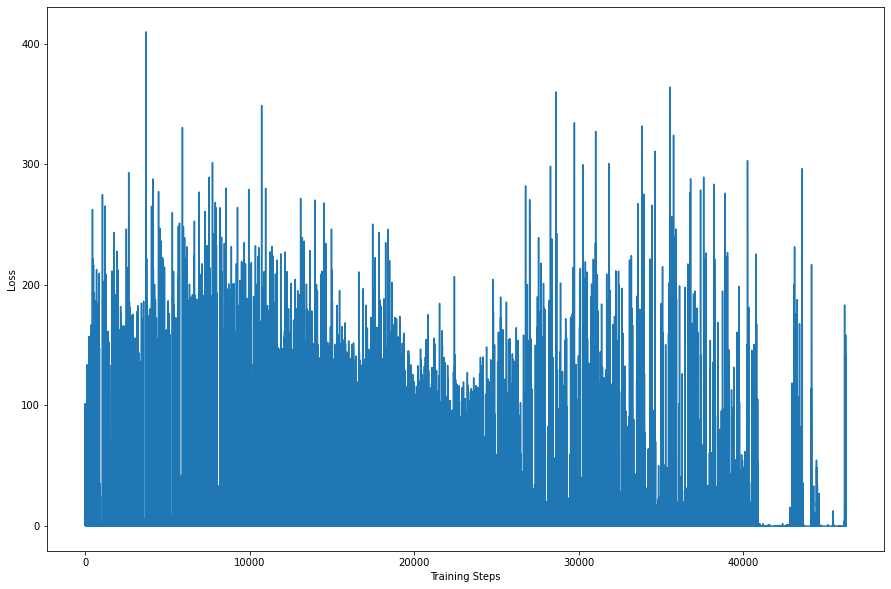

In [6]:
losses = np.array(losses)
plt.figure(figsize=(15,10))
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.plot(losses)

In [8]:
max_games = 1000
wins = 0
for i in range(max_games):
  win = test_model(model, mode='random', display=False)
  if win:
    wins += 1

win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games, wins))
print("Win percentage: {}".format(win_perc))

Games played: 1000, # of wins: 789
Win percentage: 0.789


In [9]:
test_model(model, mode='random', display=True)

Initial State:
[[' ' ' ' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' '+' ' ']
 ['-' ' ' ' ' 'W']]
Move #: 0; Taking Action: r
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' '+' ' ']
 ['-' ' ' ' ' 'W']]
Move #: 1; Taking Action: d
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']
 ['-' ' ' ' ' 'W']]
Game Won! Reward: 10


True